# Regressorion with Orbit - Advance

In this demo, we want to demonstartate further how to config orbit to perform regressions with time-series analysis.  The config including different regularizations and we use a simulated data set to compare against ground truth. 

In [1]:
import pandas as pd
import numpy as np
import gc

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from orbit.dlt import DLT
from orbit.lgt import LGT

from orbit.utils.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative

In [2]:
# randomization is using numpy with this version
print(np.__version__)

1.18.2


## Simulation of Regression with Trend

Let's make a vanila problem with observation(t) = trend(t) + regression

In [3]:
# To scale regressor values in a nicer way
REG_BASE = 1000
SEED = 2020
NUM_OF_REGRESSORS = 5
COEFS= np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)
COEFS

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [4]:
raw_df, trend, seas, coefs = make_ts_multiplicative(
    series_len=200, seasonality=52, coefs=COEFS,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=1.0,
    regression_sparsity=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)
coefs

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [5]:
raw_df.head(5)

,response,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,date
0,1865.0,0.0,1842.0,2548.0,1047.0,0.0,2016-01-10
1,1680.0,1755.0,1858.0,1871.0,912.0,0.0,2016-01-17
2,2390.0,1429.0,2055.0,1936.0,1974.0,1765.0,2016-01-24
3,984.0,0.0,1272.0,1469.0,0.0,3932.0,2016-01-31
4,1259.0,2447.0,0.0,819.0,1753.0,2383.0,2016-02-07


In [6]:
print(coefs)

[ 0.15602066  0.05231785  0.16325487 -0.11182046  0.0027203 ]


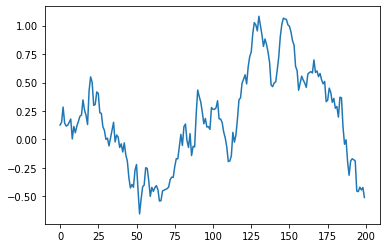

In [7]:
plt.plot(trend)

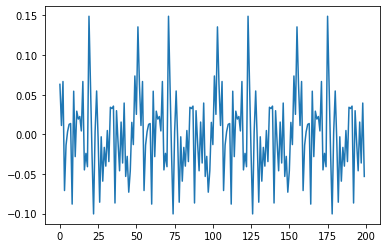

In [8]:
plt.plot(seas)

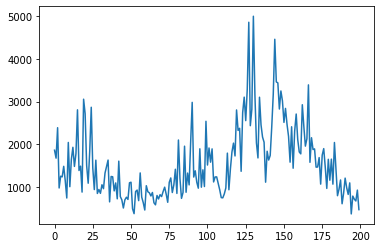

In [9]:
plt.plot(raw_df['response'])

## Estimating Coefficients I - full relevance

Assume we observe the data frame `df` and the scaler `REG_BASE`

In [10]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [11]:
mod_lasso = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
mod_auto_ridge = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [13]:
mod_fixed_ridge1 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.5] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
mod_fixed_ridge2 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.05] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

In [ ]:
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

In [ ]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=1.0, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

The result looks reasonable to the true coefficients.

## Checking Model Convergence and Posterior Distribution

In [ ]:
_ = mod_lasso.predict(df)
_ = plot_posterior_params(mod_lasso, kind='density')
_ = plot_posterior_params(mod_lasso, kind='trace')

## Estimating Coefficients II - high sparsity

In [ ]:
NUM_OF_REGRESSORS = 25
REG_RELEVANCE = 0.8
COEFS= np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)
COEFS

In [ ]:
raw_df, trend, seas, coefs = make_ts_multiplicative(
    series_len=200, seasonality=52, coefs=COEFS, regressor_relevance=REG_RELEVANCE,
    regressor_log_loc=0.0, regressor_log_scale=0.2, noise_to_signal_ratio=1.0,
    regression_sparsity=0.5, obs_val_base=1000, regresspr_val_base=REG_BASE, trend_type='rw',
    seas_scale=.05, response_col='response', seed=SEED
)
raw_df.head(5)

In [ ]:
print(coefs)

In [ ]:
df = raw_df.copy()
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "response"
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [ ]:
mod_lasso = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)

In [ ]:
mod_auto_ridge = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

In [ ]:
mod_fixed_ridge1 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

In [ ]:
mod_fixed_ridge2 = DLT(
    response_col=response_col,
    date_col="date",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.1] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

In [ ]:
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2.posterior_samples['rr_beta'], axis=0)

In [ ]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=1.0, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

Again, with high dimensional data, the result looks reasonable to the true coefficients with irrelevant regressors fed into the model.